In [1]:
from __future__ import division, print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyedflib
import utils

/home/ntapia/miniconda3/envs/idp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def get_file_paths():
    # Only those registers that have marks from two experts
    reg_ids = ['01', '02', '03', '05', '06', '07', '09', '10', '11', '12', '13', '14', '17', '18', '19']

    path_rec = "ssdata_mass/register/"
    rec_preamble = "01-02-00"
    rec_postamble = " PSG.edf"

    path_marks_1 = "ssdata_mass/label/marks/e1/"
    marks_1_preamble = "01-02-00"
    marks_1_postamble = " SpindleE1.edf"

    path_marks_2 = "ssdata_mass/label/marks/e2/"
    marks_2_preamble = "01-02-00"
    marks_2_postamble = " SpindleE2.edf"

    path_states = "ssdata_mass/label/states/"
    states_preamble = "01-02-00"
    states_postamble = " Base.edf"

    # Build list of paths
    data_path_list = []
    for i in range(len(reg_ids)):
        path_eeg_file = path_rec + rec_preamble + reg_ids[i] + rec_postamble
        path_states_file = path_states + states_preamble + reg_ids[i] + states_postamble
        path_marks_1_file = path_marks_1 + marks_1_preamble + reg_ids[i] + marks_1_postamble
        path_marks_2_file = path_marks_2 + marks_2_preamble + reg_ids[i] + marks_2_postamble
        # Save data
        ind_dict = {'file_eeg': path_eeg_file, 'file_states': path_states_file,
                    'file_marks_1': path_marks_1_file, 'file_marks_2': path_marks_2_file,
                    'reg_id': reg_ids[i]}
        data_path_list.append(ind_dict)
    print(len(data_path_list), 'records in MASS dataset.')
    return data_path_list

In [199]:
def read_eeg(path_eeg_file):
    channel = 13
    file = pyedflib.EdfReader(path_eeg_file)
    signal = file.readSignal(channel)
    signal_duration = file.file_duration
    file._close()
    del file
    return signal, signal_duration

def read_states(path_states_file, signal_seconds, dur_page):
    file = pyedflib.EdfReader(path_states_file)
    annotations = file.readAnnotations()
    file._close()
    del file
    onsets = np.array(annotations[0])
    stages_str = annotations[2]
    #print(stages_str[0])
    stages_char = [single_annot[-1] for single_annot in stages_str]
    total_annots = len(stages_char)
    total_pages = int(np.ceil(signal_seconds / dur_page))
    n2_pages_onehot = np.zeros(total_pages, dtype=np.int32)
    for i in range(total_annots):
        if stages_char[i] == '2':
            page_idx = int(np.round(onsets[i] / dur_page))
            n2_pages_onehot[page_idx] = 1
    n2_pages = np.where(n2_pages_onehot == 1)[0]
    # Drop first, last and second to last page of the whole registers if they where selected
    last_page = total_pages - 1
    n2_pages = n2_pages[(n2_pages != 0) & (n2_pages != last_page) & (n2_pages != last_page - 1)]
    n2_pages = np.array(n2_pages, dtype=np.int32)
    return n2_pages

def read_marks(path_marks_file, signal_length, signal_duration):
    file = pyedflib.EdfReader(path_marks_file)
    annotations = file.readAnnotations()
    file._close()
    del file
    onsets = np.array(annotations[0])
    durations = np.array(annotations[1])
    offsets = onsets + durations
    # Translate to a sample step:
    #fs = signal_length/signal_duration
    fs = 256
    #fs = 256.016
    start_samples = np.array(np.round(onsets * fs), dtype=np.int32)
    end_samples = np.array(np.round(offsets * fs), dtype=np.int32)
    #start_samples = np.array(np.round(onsets * 256.0177), dtype=np.int32)
    #end_samples = np.array(np.round(offsets * 256.0177), dtype=np.int32)
    marks = np.stack((start_samples, end_samples), axis=1)
    return marks

def plot_page(reg_id, signal, pages, marks_1, marks_2, fs, dur_page, reg_idx, page_idx):
    this_reg_id = reg_id[reg_idx]
    this_signal = signal[reg_idx]
    this_pages = pages[reg_idx]
    this_marks_1 = marks_1[reg_idx]
    this_marks_2 = marks_2[reg_idx]
    sample_start = int(this_pages[page_idx]*fs*dur_page)
    sample_end = int((this_pages[page_idx]+1)*fs*dur_page)
    signal_segment = this_signal[sample_start:sample_end]
      
    marks_1_segment = this_marks_1[sample_start:sample_end]
    marks_2_segment = this_marks_2[sample_start:sample_end]
    # artificially displaced one second before
    #marks_1_segment = this_marks_1[(sample_start-fs):(sample_end-fs)]
    #marks_2_segment = this_marks_2[(sample_start-fs):(sample_end-fs)]
    start_time = sample_start/fs
    end_time = sample_end/fs
    plt.figure(figsize=(16, 4))
    time_axis = np.arange(start_time, end_time, 1/fs)
    plt.plot(time_axis, signal_segment)
    plt.plot(time_axis, 30*marks_1_segment - 100)
    plt.plot(time_axis, 30*marks_2_segment - 150)
    plt.title("reg "+this_reg_id+", page "+str(this_pages[page_idx])+"("+str(page_idx)+"/"+str(len(this_pages))+")")
    plt.xlim([time_axis[0], time_axis[-1]])
    plt.show()

In [200]:
#fs = 256.0177   # register 01
fs = 256
#fs = 256.0182  # register 14
#fs = 256.0180905943043  # register 07
dur_page = 20
data_path_list = get_file_paths()

# load
reg_id = []
signal = []
pages = []
marks_1 = []
marks_2 = []

n_data = len(data_path_list)
#n_data = 1
#for i in [5]:
for i in range(n_data):
    # Read EEG Signal, States, and Marks
    path_eeg_file = data_path_list[i]['file_eeg']
    path_states_file = data_path_list[i]['file_states']
    path_marks_1_file = data_path_list[i]['file_marks_1']
    path_marks_2_file = data_path_list[i]['file_marks_2']
    this_signal, this_signal_duration = read_eeg(path_eeg_file)
    this_n2_pages = read_states(path_states_file, this_signal.shape[0]/fs, dur_page)
    this_marks_1 = read_marks(path_marks_1_file, this_signal.shape[0], this_signal_duration)
    this_marks_2 = read_marks(path_marks_2_file, this_signal.shape[0], this_signal_duration)
    # Transform marks into 0_1 format
    this_marks_1 = utils.inter2seq(this_marks_1, 0, this_signal.shape[0] - 1)
    this_marks_2 = utils.inter2seq(this_marks_2, 0, this_signal.shape[0] - 1)
    # Save data
    reg_id.append(data_path_list[i]['reg_id'])
    signal.append(this_signal)
    pages.append(this_n2_pages)
    marks_1.append(this_marks_1)
    marks_2.append(this_marks_2)
    print(i)

15 records in MASS dataset.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


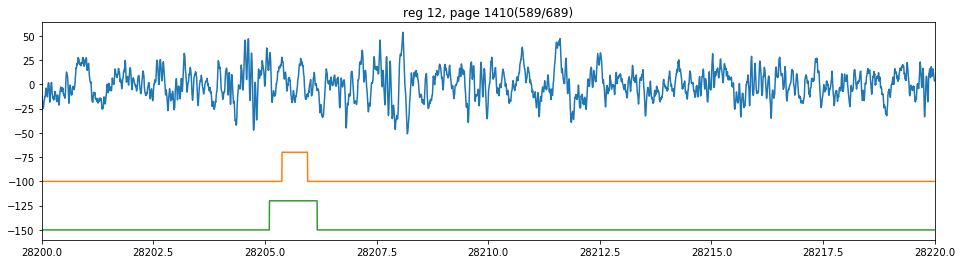

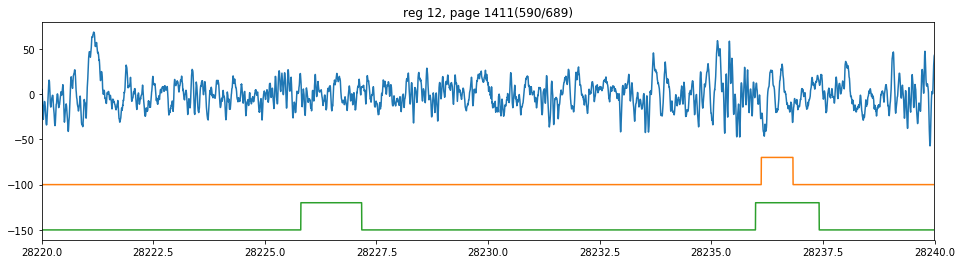

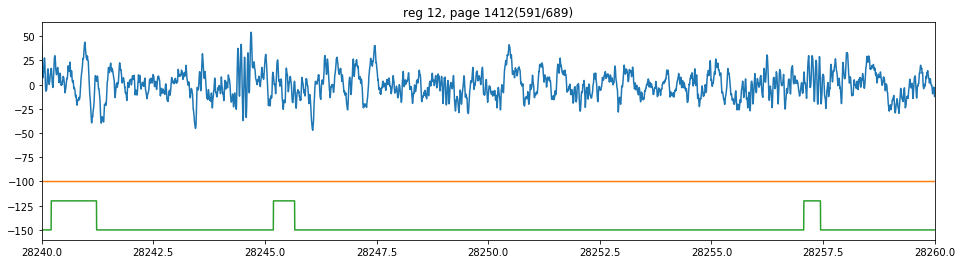

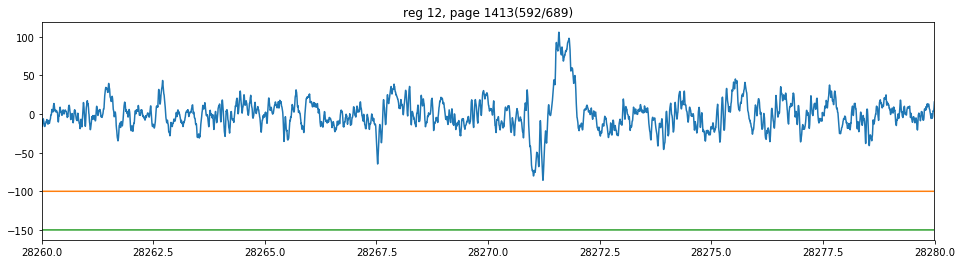

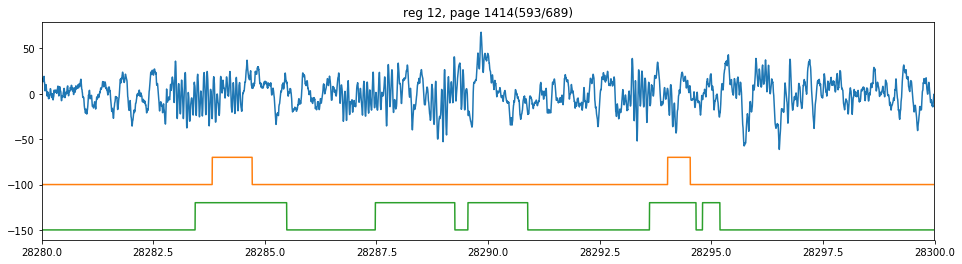

In [198]:
# Marks en registro 14 parecen estar desplazadas (adelantadas al verdadero spindle), reg_idx = 11
fs=256
reg_idx = 9
page_idx = len(pages[reg_idx])-100
plot_page(reg_id, signal, pages, marks_1, marks_2, fs, dur_page, reg_idx, page_idx)
plot_page(reg_id, signal, pages, marks_1, marks_2, fs, dur_page, reg_idx, page_idx+1)
plot_page(reg_id, signal, pages, marks_1, marks_2, fs, dur_page, reg_idx, page_idx+2)
plot_page(reg_id, signal, pages, marks_1, marks_2, fs, dur_page, reg_idx, page_idx+3)
plot_page(reg_id, signal, pages, marks_1, marks_2, fs, dur_page, reg_idx, page_idx+4)

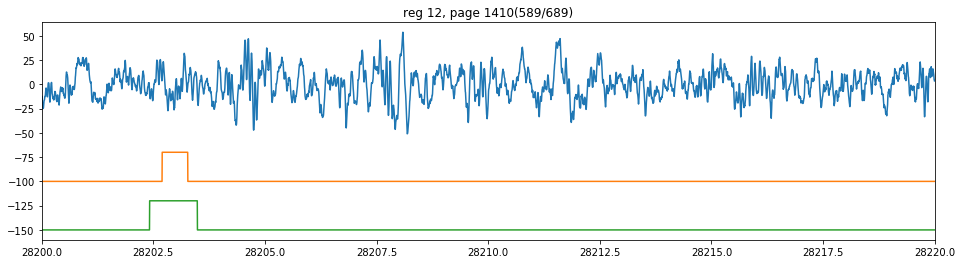

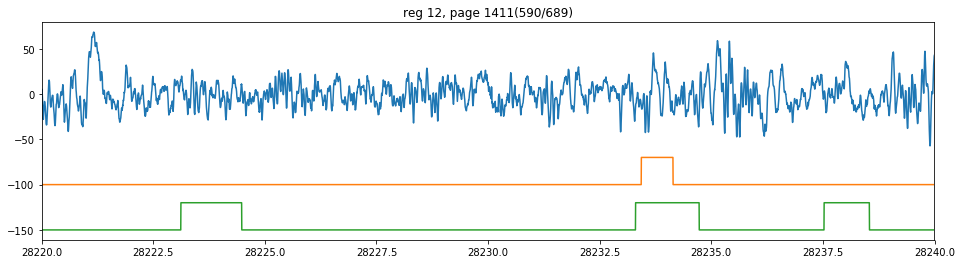

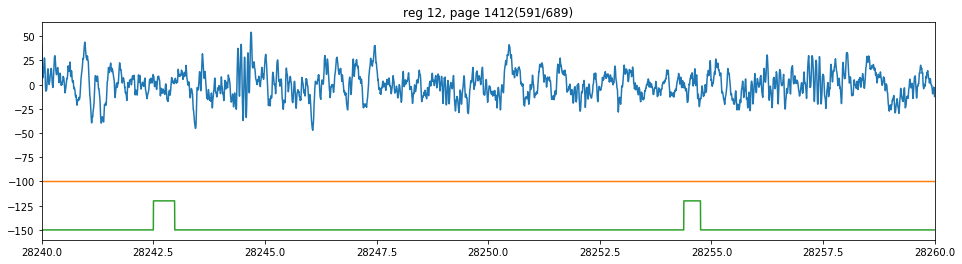

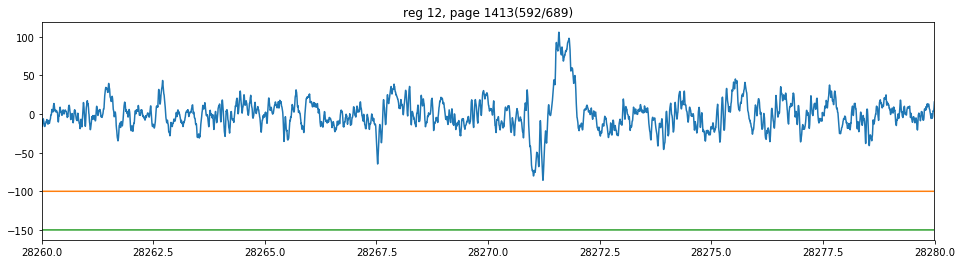

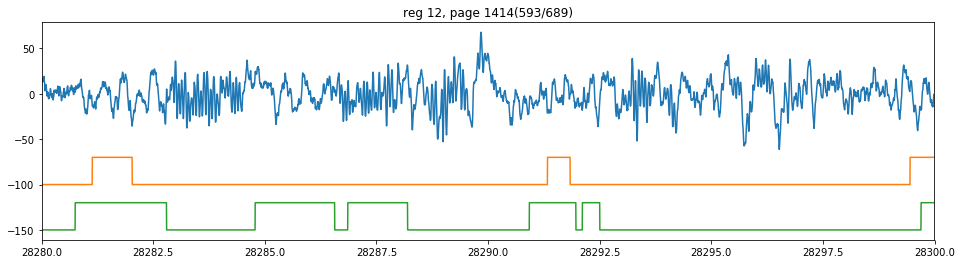

In [202]:
# Marks en registro 14 parecen estar desplazadas (adelantadas al verdadero spindle), reg_idx = 11
fs=256
reg_idx = 9
page_idx = len(pages[reg_idx])-100
plot_page(reg_id, signal, pages, marks_1, marks_2, fs, dur_page, reg_idx, page_idx)
plot_page(reg_id, signal, pages, marks_1, marks_2, fs, dur_page, reg_idx, page_idx+1)
plot_page(reg_id, signal, pages, marks_1, marks_2, fs, dur_page, reg_idx, page_idx+2)
plot_page(reg_id, signal, pages, marks_1, marks_2, fs, dur_page, reg_idx, page_idx+3)
plot_page(reg_id, signal, pages, marks_1, marks_2, fs, dur_page, reg_idx, page_idx+4)